**Carbon Intensity -- Average + Marginal Data**

In [5]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks

sns.set_theme(style='ticks', context='paper')

In [22]:
# Constants
avg_cols = ['date','hour','day','month','weekday','ci']
marg_cols = ['date','hour','ci']
region_prefixes = ['gb', 'de', 'ca', 'tx', 'za', 'tyo', 'nsw']
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
short_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
months_num = range(1,13)
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
weekends = ['Saturday', 'Sunday']
short_days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'Mon']
shifts = [-1, -2, 7, 5, -2, -9, -9]  # according to BST now (UTC+1)
season_names = ['Winter', 'Spring', 'Summer', 'Autumn']
short_seasons = ['spr', 'sum', 'aut', 'win']

In [18]:
# Functions
def load_df(region, year, ci_type):
    if ci_type == 'avg':
        df = pd.read_csv(f'../data/intensity/avg-{region}-{year}.csv', names=avg_cols, skiprows=1)
    else:
        df = pd.read_csv(f'../data/intensity/marg-{region}-{year}.csv', names=marg_cols, skiprows=1)

    df_ci = df[['date', 'hour', 'ci']]
    df_ci = df_ci.rename(columns={'ci': region + '_ci'})

    return (df, df_ci)

def shift_by_timezone(data, shift):
    shifted = pd.concat([data[shift:], data[:shift]])
    shifted['hour'] = data['hour']
    return shifted

In [34]:
# Plot Weekly Analysis with Windows of Low-Carbon Intensity Highlighted (!)
def plot_weekly_analysis_compare_all(window_width=8):
    # Weekly Analysis
    f, axs = plt.subplots(ncols=1, nrows=6, sharex=True, figsize=(6,6))
    f.tight_layout(pad=0)
    f.text(-0.075, 0.5, 'Average Carbon Intensity (gCO2e/kWh)', ha='center', va='center', rotation='vertical')

    # Plot Average Carbon Intensity w/ Error and Low-Carbon Windows for Each region
    for ax, region, label, shift in zip(axs, [gb, de, ca, tx, za, tyo, nsw], region_prefixes, shifts):
        data_by_weekday = region.groupby('weekday', as_index=False, sort=False)
        full_week_ci = []
        full_week_times = []
        full_week_err_low = []
        full_week_err_high = []
        full_week_medians = []

        for day, num in zip(days, range(0, 7)):
            day_data = data_by_weekday.get_group(day)
            avg_day_ci = day_data.groupby('hour', as_index=False, sort=False)['ci'].mean()
            avg_day_sem = day_data.groupby('hour', as_index=False, sort=False)['ci'].sem() 
            confidence_int = 1.96 * avg_day_sem['ci']
            ci_low = avg_day_ci['ci'] - confidence_int
            ci_high = avg_day_ci['ci'] + confidence_int
            time = avg_day_ci.index + (24 * num)

            full_week_ci = np.concatenate((full_week_ci, avg_day_ci['ci'].values))
            full_week_times = np.concatenate((full_week_times, time))
            full_week_err_low = np.concatenate((full_week_err_low, ci_low))
            full_week_err_high = np.concatenate((full_week_err_high, ci_high))

            full_week_medians.append(avg_day_ci['ci'].median())

        shifted_full_week = np.roll(full_week_ci, -shift)
        shifted_full_week_err_low = np.roll(full_week_err_low, -shift)
        shifted_full_week_err_high = np.roll(full_week_err_high, -shift)
        sns.lineplot(y=shifted_full_week, x=full_week_times, ax=ax)
        ax.fill_between(full_week_times, shifted_full_week_err_low, shifted_full_week_err_high, alpha=0.15)

        ax.set_ylabel(label)
        ax.set_xlim(0, 24 * 7)
        ticks = range(0, 24 * 7 + 1, 24)
        minor_ticks = range(0, 24 * 7 + 1, 6)
        ax.set_xticks(ticks)
        ax.set_xticks(minor_ticks, minor=True)
        ax.set_xticklabels(short_days)

        # Plot Low Carbon Windows
        weekly_avg_median = sum(full_week_medians) / len(full_week_medians)
        peaks, props = find_peaks(-shifted_full_week, prominence=1, width=window_width, height=-weekly_avg_median)

        for left, right in zip(props['left_ips'], props['right_ips']):
            ax.axvspan(left, right, color='green', alpha=0.3)

    ax.set(xlabel="Weekday")
    f.align_ylabels()

In [9]:
# Average CI Data -- from Electricity Maps

# 2024
(gb, gb_ci) = load_df('gb', '2024', 'avg')  # Great Britain
(de, de_ci) = load_df('de', '2024', 'avg')  # Germany
(ca, ca_ci) = load_df('ca', '2024', 'avg')  # California
(tx, tx_ci) = load_df('tx', '2024', 'avg')  # Texas
(za, za_ci) = load_df('za', '2024', 'avg')  # South Africa
(tyo, tyo_ci) = load_df('tyo', '2024', 'avg')  # Tokyo
(nsw, nsw_ci) = load_df('nsw', '2024', 'avg')  # New South Wales

all_2024_avg_data = pd.concat([gb_ci, de_ci, ca_ci, tx_ci, za_ci, tyo_ci, nsw_ci], axis=1)
all_2024_avg_data.describe()

,gb_ci,de_ci,ca_ci,tx_ci,za_ci,tyo_ci,nsw_ci
count,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000
mean,105.687816,275.124187,168.426444,301.854707,656.719498,452.669816,500.155390
std,54.942573,111.280334,75.313022,79.434659,31.210846,68.287553,147.710867
min,7.700000,66.850000,20.190000,99.530000,547.830000,140.510000,129.010000
25%,60.955000,180.865000,103.237500,243.527500,634.830000,414.535000,380.847500
50%,94.525000,273.190000,177.495000,300.610000,658.475000,493.680000,547.050000
75%,143.377500,359.952500,235.060000,360.155000,680.572500,498.850000,618.405000
max,277.980000,563.230000,325.640000,486.480000,740.720000,508.340000,748.000000


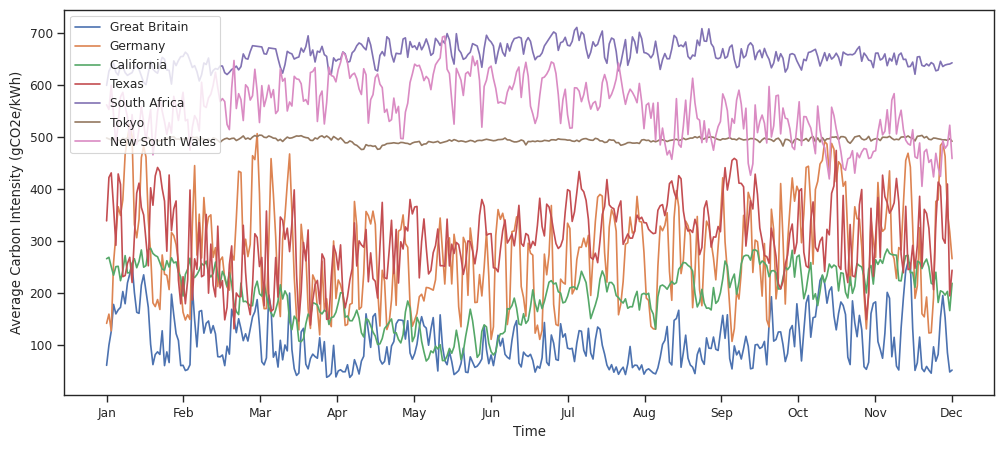

In [15]:
# Plot Smoothed Regional Comparison
plt.figure(figsize=(12,5))
gb_ci.groupby(['date'])['gb_ci'].median().plot(label='Great Britain')
de_ci.groupby(['date'])['de_ci'].median().plot(label='Germany')
ca_ci.groupby(['date'])['ca_ci'].median().plot(label='California')
tx_ci.groupby(['date'])['tx_ci'].median().plot(label='Texas')
za_ci.groupby(['date'])['za_ci'].median().plot(label='South Africa')
tyo_ci.groupby(['date'])['tyo_ci'].median().plot(label='Tokyo')
nsw_ci.groupby(['date'])['nsw_ci'].median().plot(label='New South Wales')
plt.legend(loc='upper left')
plt.xticks(np.linspace(0,365,12), short_months)
plt.xlabel('Time')
plt.ylabel('Average Carbon Intensity (gCO2e/kWh)')
plt.show()

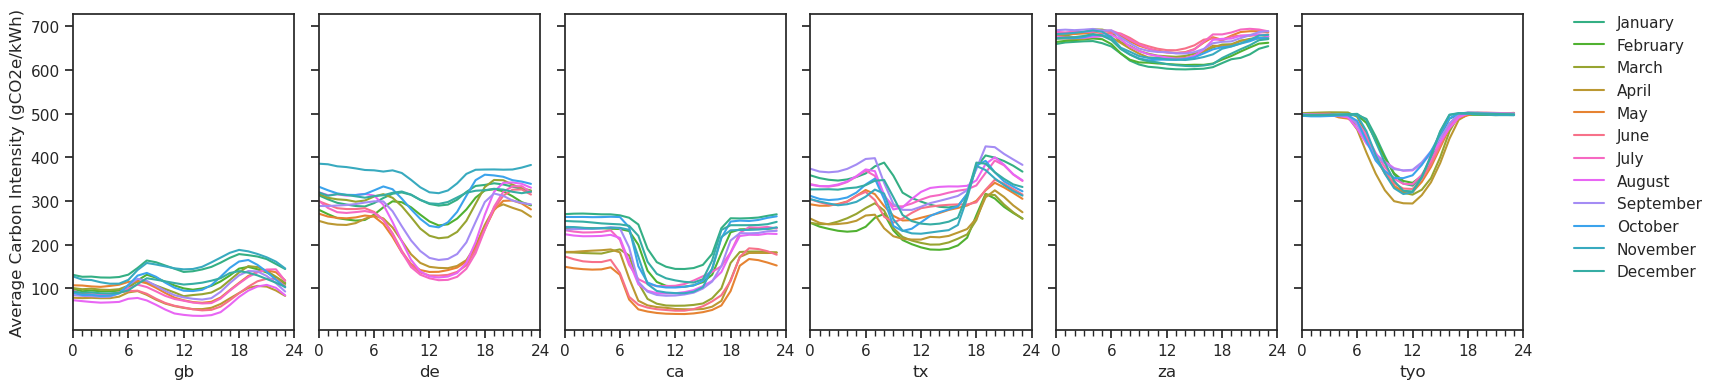

In [35]:
# Monthly Analysis
sns.set_theme(style='ticks')

f, axs = plt.subplots(ncols=6, nrows=1, sharey=True, sharex=True, figsize=(15,3.5))
f.tight_layout(pad=0)
palette = sns.palettes._ColorPalette(np.roll(np.flip(sns.color_palette("husl", 12), axis=0), 6, axis=0))

for ax, region, label, shift in zip(axs, [gb, de, ca, tx, za, tyo, nsw], region_prefixes, shifts):
    data_by_month = region.groupby('month', as_index=False, sort=False)

    for month_num, colour, month_name in zip(months_num, palette, months):
        month_data = data_by_month.get_group(month_num)
        avg_day_ci = month_data.groupby('hour', as_index=False, sort=False)['ci'].mean()
        shifted = shift_by_timezone(avg_day_ci, shift)
        ax.plot(avg_day_ci['hour'], shifted['ci'].values, color=colour, label=month_name)

    ax.set_xlabel(label)
    ax.set_xlim(0, 24)
    ticks = range(0, 25, 6)
    minor_ticks = range(0, 25)
    ax.set_xticks(ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_xticklabels([f'{int(tick)}' for tick in ticks])

handles, labels = ax.get_legend_handles_labels()
f.legend(handles, months, loc='upper right', bbox_to_anchor=(1.12, 1.02), frameon=False)
axs[0].set(ylabel='Average Carbon Intensity (gCO2e/kWh)')

plt.savefig('../image/avg-ci-hist-by-month-2024.pdf', dpi=300, bbox_inches='tight')
plt.show()

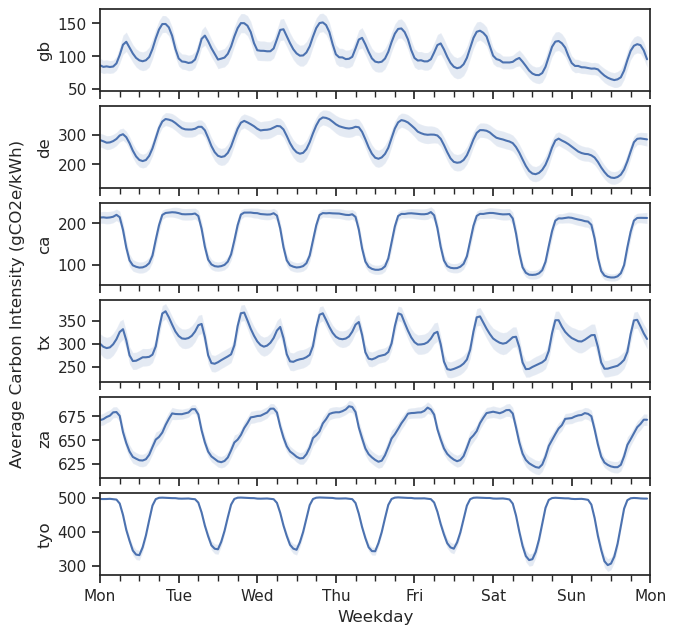

In [36]:
# Weekly Analysis
plot_weekly_analysis_compare_all(window_width=24)
plt.savefig('../image/avg-weekly-ci-pattern-2024.pdf', dpi=300, bbox_inches='tight')
plt.show()

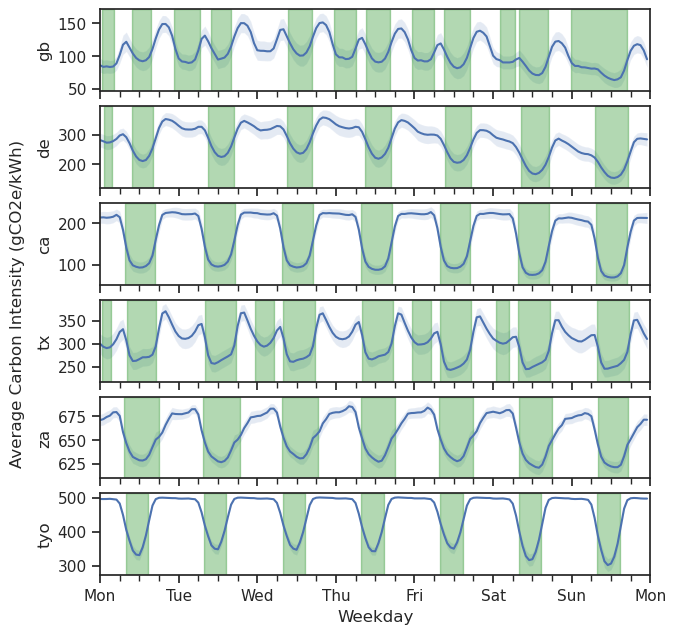

In [37]:
plot_weekly_analysis_compare_all(window_width=2)
plt.savefig('../image/avg-weekly-ci-windows-2024.pdf', dpi=300, bbox_inches='tight')
plt.show()